In [1]:
# import module
import torchvision
from torchvision import transforms

In [2]:
image_path = './'
transforms = transforms.Compose(transforms=[
    transforms.ToTensor()
])

In [3]:
mnist_dataset = torchvision.datasets.MNIST(root=image_path,
                                           train=True,
                                           transform=transforms,
                                           download=True)

In [19]:
from torch.utils.data import Subset
import torch
from torch import nn

In [15]:
# valid dataset 
mnist_valid_dataset = Subset(dataset=mnist_dataset,
                             indices=torch.arange(end=10000))
# train dataset
mnist_train_dataset = Subset(dataset=mnist_dataset,
                             indices=torch.arange(start=10000,
                                                  end=len(mnist_dataset)))
# test dataset
mnist_test_dataset = torchvision.datasets.MNIST(root=image_path,
                                                train=False,
                                                transform=transforms,
                                                download=False)

In [16]:
from torch.utils.data import DataLoader

In [17]:
batch_size = 64
torch.manual_seed(1)

train_dl = DataLoader(dataset=mnist_dataset,
                      batch_size=batch_size,
                      shuffle=True,)

valid_dl = DataLoader(dataset=mnist_dataset,
                      batch_size=batch_size,
                      shuffle=False)

In [20]:
model = nn.Sequential()

In [32]:
model.add_module(name='conv1',
                 module=nn.Conv2d(in_channels=1, 
                                  out_channels=32,
                                  kernel_size=5,
                                  padding=2))

model.add_module(name='relu1',
                 module=nn.ReLU())

model.add_module(name='pool1',
                 module=nn.MaxPool2d(kernel_size=2)) # stride is eq to pooling kernel size if it not spec.
model.add_module(name='conv2',
                 module=nn.Conv2d(in_channels=32,
                                  out_channels=64,
                                  kernel_size=5,
                                  padding=2))
model.add_module(name='relu2',
                 module=nn.ReLU())
model.add_module(name='pool2',
                 module=nn.MaxPool2d(kernel_size=2))

# flatten
model.add_module(name='flatten',
                 module=nn.Flatten())
# fc1
model.add_module(name='fc1',
                 module=nn.Linear(in_features=3136,
                                  out_features=1024))
# relu
model.add_module(name='relu3',
                 module=nn.ReLU())
# dropout
model.add_module(name='dropout',
                 module=nn.Dropout(p=0.5))
# fc2
model.add_module(name='fc2',
                 module=nn.Linear(in_features=1024,
                                  out_features=10))

In [33]:
x = torch.ones((4, 1, 28, 28))
model(x).shape

torch.Size([4, 10])

In [34]:
# Loss & Optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(),
                             lr=0.001)

In [39]:
# train

def train(model, num_epochs, train_dl, valid_dl):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs
    
    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_dl:
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_hist_train[epoch] += loss.item() * y_batch.size(0)
            is_correct = (torch.argmax(input=pred, dim=1) == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum()
        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)
        
        # mode eval
        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)
                loss_hist_valid[epoch] += loss.item() * y_batch.size(0)
                is_correct = (torch.argmax(input=pred, dim=1) == y_batch).float()
                accuracy_hist_valid[epoch] += is_correct.sum()
        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        accuracy_hist_valid[epoch] /= len(valid_dl.dataset)
        
        print(f'Epoch {epoch +1} accuracy: '
              f'{accuracy_hist_train[epoch]: .4f} val_accuracy: '
              f'{accuracy_hist_valid[epoch]: .4f}')
        
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid
        

In [40]:
torch.manual_seed(1)
num_epochs = 20
hist = train(model, num_epochs, train_dl, valid_dl)

Epoch 1 accuracy:  0.9898 val_accuracy:  0.9893
Epoch 2 accuracy:  0.9879 val_accuracy:  0.9952
Epoch 3 accuracy:  0.9918 val_accuracy:  0.9955
Epoch 4 accuracy:  0.9938 val_accuracy:  0.9909
Epoch 5 accuracy:  0.9948 val_accuracy:  0.9980
Epoch 6 accuracy:  0.9957 val_accuracy:  0.9982
Epoch 7 accuracy:  0.9958 val_accuracy:  0.9983
Epoch 8 accuracy:  0.9961 val_accuracy:  0.9986
Epoch 9 accuracy:  0.9971 val_accuracy:  0.9990
Epoch 10 accuracy:  0.9971 val_accuracy:  0.9992
Epoch 11 accuracy:  0.9978 val_accuracy:  0.9988
Epoch 12 accuracy:  0.9979 val_accuracy:  0.9994
Epoch 13 accuracy:  0.9979 val_accuracy:  0.9992
Epoch 14 accuracy:  0.9974 val_accuracy:  0.9995
Epoch 15 accuracy:  0.9980 val_accuracy:  0.9993
Epoch 16 accuracy:  0.9985 val_accuracy:  0.9994
Epoch 17 accuracy:  0.9980 val_accuracy:  0.9996
Epoch 18 accuracy:  0.9984 val_accuracy:  0.9982
Epoch 19 accuracy:  0.9983 val_accuracy:  0.9993
Epoch 20 accuracy:  0.9983 val_accuracy:  0.9991


In [41]:
import matplotlib.pyplot as plt
import numpy as np

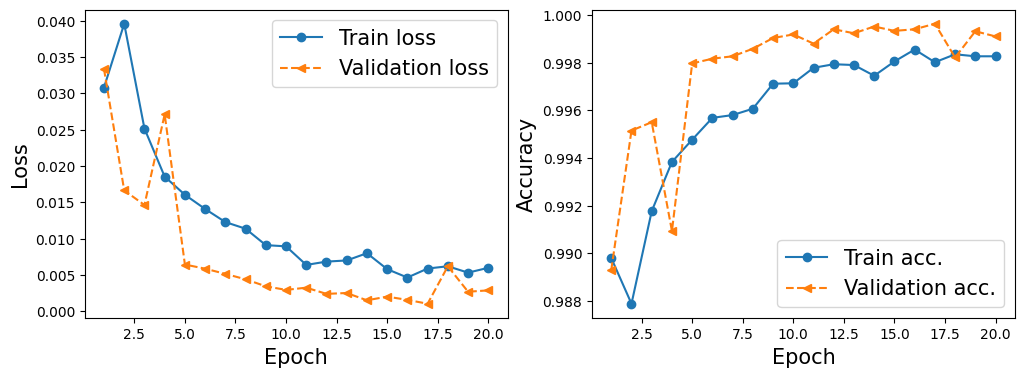

In [45]:
x_arr = np.arange(len(hist[0])) + 1
fig = plt.figure(figsize=(12, 4))


ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0], '-o', label='Train loss')
ax.plot(x_arr, hist[1], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)


ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist[2], '-o', label='Train acc.')
ax.plot(x_arr, hist[3], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

plt.show()

In [46]:
# test evaluation
pred = model(mnist_test_dataset.data.unsqueeze(1) / 255.) # unsqueeze is for add channel dim at pos 1 (N, C, H, W)
is_correct = (torch.argmax(input=pred, dim=1) == mnist_test_dataset.targets).float()
print(f'Test accuracy: {is_correct.mean(): .4f}')

Test accuracy:  0.9932


In [63]:
example = next(iter(mnist_test_dataset))
example

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [66]:
image, attribut = example
image.shape, attribut

(torch.Size([1, 28, 28]), 7)

In [57]:
mnist_test_dataset[0][0][0, :, :]

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

In [68]:
from itertools import islice

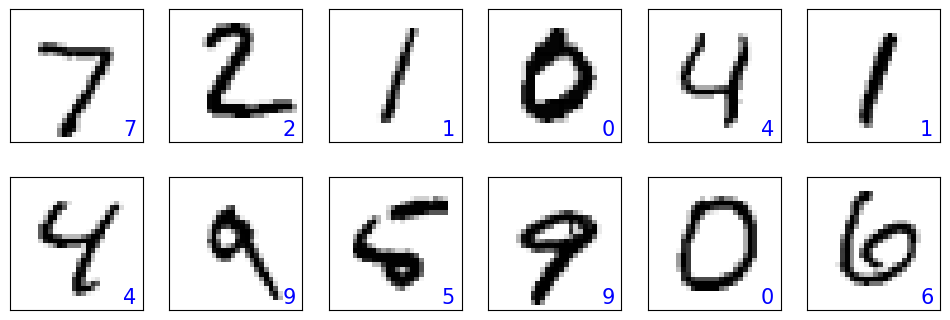

In [69]:
fig = plt.figure(figsize=(12, 4))

for i, (image, attribut) in islice(enumerate(mnist_test_dataset), 12):
    
    ax = fig.add_subplot(2, 6, i+1)
    ax.set_xticks([]), ax.set_yticks([])
    
    pred = model(image.unsqueeze(1))    # [1, H, W] => [1, 1, H, W]
    y_pred = torch.argmax(input=pred)
    image2D = image.squeeze(0) # [1, H, W] => [H, W]
    
    ax.imshow(image2D, cmap='gray_r')
    ax.text(0.9, 0.1, y_pred.item(),
            size=15, color='blue',
            horizontalalignment='center',
            verticalalignment='center',
            transform=ax.transAxes)
plt.show()

In [98]:
# X_test_subset = [(image, attribut) for (image, attribut) in islice(mnist_test_dataset, 12)]
X_test_subset = [(image, attribut) for (image, attribut) in islice(mnist_test_dataset, 5000)]
test_pred = [torch.argmax(model.forward(image.unsqueeze(1))) for image, _ in X_test_subset]

In [99]:
misclassified_images_labels = [(image, attribut, pred) for (image, attribut), pred in zip(X_test_subset, test_pred) 
                        if pred.item() != attribut] 

len(misclassified_images_labels)


49

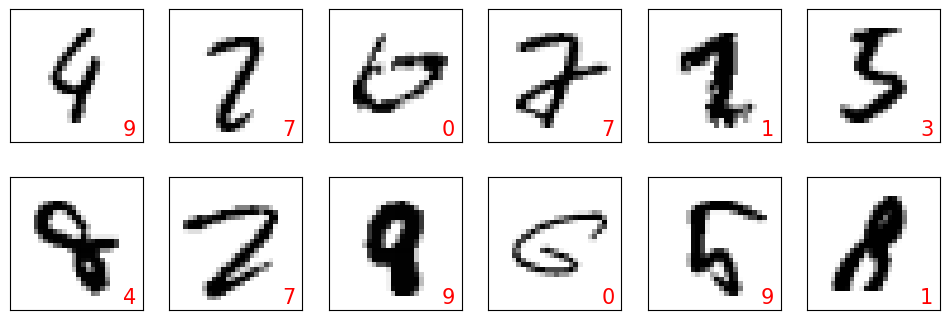

In [100]:
fig = plt.figure(figsize=(12, 4))

for i in range(12):
    image, attribut, pred = misclassified_images_labels[i]
    ax = fig.add_subplot(2, 6, i+1)
    ax.set_xticks([]), ax.set_yticks([])

    image2D = image.squeeze(0) # [1, H, W] => [H, W]
    ax.imshow(image2D, cmap='gray_r')
    ax.text(0.9, 0.1, pred.item(),
            size=15, color='red',
            horizontalalignment='center',
            verticalalignment='center',
            transform=ax.transAxes)
plt.show()